# Прогнозирование оттока клиентов

<a id=content></a>
# Содержание.

- [**1. Загрузка библиотек и данных.**](#1)
- [**2. Исследовательский анализ данных (EDA).**](#2)
- [**3. Модель прогнозирования оттока пользователей.**](#3)
- [**4. Кластеризация пользователей.**](#4)
- [**5. Выводы и базовые рекомендации по работе с клиентами.**](#5)

<a id=1></a>
# 1. Загрузка библиотек и данных.
[содержание](#content)

Загружаем библиотеки в одельноя ячейке:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
gym_churn_original = pd.read_csv('datasets/gym_churn.csv')
gym_churn_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [3]:
gym_churn_original.head().T

,0,1,2,3,4
gender,1.000000,0.000000,0.000000,0.000000,1.000000
Near_Location,1.000000,1.000000,1.000000,1.000000,1.000000
Partner,1.000000,0.000000,1.000000,1.000000,1.000000
Promo_friends,1.000000,0.000000,0.000000,1.000000,1.000000
Phone,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,6.000000,12.000000,1.000000,12.000000,1.000000
Group_visits,1.000000,1.000000,0.000000,1.000000,0.000000
Age,29.000000,31.000000,28.000000,33.000000,26.000000
Avg_additional_charges_total,14.227470,113.202938,129.448479,62.669863,198.362265
Month_to_end_contract,5.000000,12.000000,1.000000,12.000000,1.000000


#### В нашем распоряжении данные без пропусков. 4000 наблюдений - хороший источник для обучения модели. Все бинарные признаки уже представлены в необходимом виде. Все данные имеют числовой формат. 

#### Так же отметим, что искомая характеристика имеет бинарный вид.

<a id=2></a>
# 2. Исследовательский анализ данных (EDA).
[содержание](#content)

Первом делом приводим названия столбцов к строчному варианту:

In [4]:
gym_churn_original.columns = gym_churn_original.columns.str.lower()

Проверим распределение методом describe(). Дополнительно, создадим столбец, показывающий в % стандартное отклонение от среднего:

In [5]:
gym_churn_describe = gym_churn_original.describe().T[['mean', 'std', 'min', 'max']]
gym_churn_describe['std_percent_of_mean'] = (gym_churn_describe['std'] / gym_churn_describe['mean'])
gym_churn_describe['std_percent_of_mean'] = gym_churn_describe['std_percent_of_mean'].apply(lambda x: '{:.1%}'.format(x))
gym_churn_describe

,mean,std,min,max,std_percent_of_mean
gender,0.510250,0.499957,0.000000,1.000000,98.0%
near_location,0.845250,0.361711,0.000000,1.000000,42.8%
partner,0.486750,0.499887,0.000000,1.000000,102.7%
promo_friends,0.308500,0.461932,0.000000,1.000000,149.7%
phone,0.903500,0.295313,0.000000,1.000000,32.7%
contract_period,4.681250,4.549706,1.000000,12.000000,97.2%
group_visits,0.412250,0.492301,0.000000,1.000000,119.4%
age,29.184250,3.258367,18.000000,41.000000,11.2%
avg_additional_charges_total,146.943728,96.355602,0.148205,552.590740,65.6%
month_to_end_contract,4.322750,4.191297,1.000000,12.000000,97.0%


Распишем все значения:
- **gender**. В фитнес-центры ходят мужчины и женщины практически в равных долях.
- **near_location**. Большинство клиентов живут около зала.
- **partne**. Почти ровно половина клиентов являются сотрудниками компаний-партнёров.
- **promo_friends**. Примерно треть клиентов пришли в рамках акции "приведи друга".
- **phone**. Лишь незначительная часть клиентов не оставила контактный телефон.
- **contract_period**. Длительность абонемента по всем клиентам, в среднем, почти 5 месяцев.
- **group_visits**. Примерно 40% клиентов посещают групповые занятия.
- **age**. В залы ходят клиенты возрастом от 18 до 41 года. Средний возраст клиента - 29 лет.
- **avg_additional_charges_total**. Суммарная выручка от других услуг фитнес-центров сильно разнится. Судя по минимальному значению, измеряется в долларах. Так же, в описании не указано, является ли значение ежемесячным показателем, либо это LTV. По названию характеристики логично предположить, что это именно среднее значение (**av**era**g**e - среднее). Тем более, что значения указаны с 6 знаками после запятой. Однако, среднее в 150 долларов, и уж тем более в 550 - это слишком много. Вероятно, метрика рассчитывала среднее за время действия абонементов.
- **month_to_end_contract**. До окончания текущего действующего абонемента осталось от одного до 12 месяцев - соответствует длительности самих абонементов.
- **lifetime**. Самый "ранний" клиент посещает сеть уже более 2,5 лет.
- **avg_class_frequency_total**. Средняя частота посещений в неделю за все время с начала действия абонемента - почти два раза. Субъективно, это стандартный показатель. Кто-то вообще не ходит, а кто-то занимается 6 дней в неделю.
- **avg_class_frequency_current_month**. Средняя частота посещений в неделю за предыдущий месяц чуть ниже, чем за всё время действия абонемента, и почти полностью повторяется общее распределение.
- **gender**. Отток в текущем месяце составляет более 25%.

Проверим средние значения признаков, с разделением на две группы: ушедших в отток, и оставшихся. Дополнительно, создадим столбец с разницей средних в процентах:

In [6]:
gym_churn_groupby = gym_churn_original.groupby('churn').mean().T
gym_churn_groupby['percent_delta'] = 1 - gym_churn_groupby[1] / gym_churn_groupby[0]
gym_churn_groupby['percent_delta'] = gym_churn_groupby['percent_delta'].apply(lambda x: '{:.1%}'.format(x))
gym_churn_groupby.sort_values('percent_delta', ascending=False)

churn,0,1,percent_delta
lifetime,4.711807,0.990575,79.0%
contract_period,5.747193,1.728558,69.9%
month_to_end_contract,5.283089,1.662582,68.5%
avg_class_frequency_current_month,2.027882,1.044546,48.5%
promo_friends,0.353522,0.183789,48.0%
group_visits,0.464103,0.268615,42.1%
partner,0.534195,0.355325,33.5%
avg_additional_charges_total,158.445715,115.082899,27.4%
avg_class_frequency_total,2.024876,1.474995,27.2%
near_location,0.873086,0.768143,12.0%


Пол и наличие контактного телефона не влияют на отток. Не удивительно. Можно сразу их удалить.

In [7]:
gym_churn_drop_gf = gym_churn_original.drop(['phone', 'gender'], axis=1).copy()

Запишем бинарные признаки в отдельный лист:

In [8]:
binary_attributes_list = []
for column in gym_churn_drop_gf.drop('churn', axis=1).columns:
    binary = len(gym_churn_drop_gf[column].value_counts())
    if binary == 2:
        binary_attributes_list.append(column)
binary_attributes_list        

['near_location', 'partner', 'promo_friends', 'group_visits']

Создадим функцию:

In [9]:
def histplots_binary_attributes(data, char, list_att, fig_suptitle):
    '''
    - принимает на вход Dataframe, характеристику (название столбца),
    list (список бинарных признаков), и название общего заголовка;
    - рассчитывает размер графика (Figure) по оси х;
    - создаёт список осей (ах), исходя из количества признаков;
    - задаёт размер фигуры;
    - меняет тип данных столца характеристики на 'str' (для визуализации)
    - в цикле перебирает названия осей (ах), и передаёт в них графики
    распределения бинарных признаков из соответствующего списка;
    - строит сборный график;
    - возвращает тип данных 'int' для характеристики.
    '''
    count_binary = len(list_att)
    if count_binary <= 4:
        figsize_x = count_binary * 3
    else:
        figsize_x = 16    

    keys_axes_name = []
    for i in range(count_binary):
        keys_axes_name.append('ax'+str(i))    

    fig = plt.figure(figsize=(figsize_x, 6))
    data[char] = data[char].astype('str')
    i = 0
    for ax_n in keys_axes_name:    
        ax_n = fig.add_subplot(1, count_binary, i+1)
        sns.histplot(
            data,
            x=char,
            bins = 2,
            hue=list_att[i],
            stat='probability',
            multiple='fill',                     
            ax=ax_n)
        ax_n.set_title(list_att[i], fontsize=14)
        ax_n.set_xlabel(char, fontsize=14)
        ax_n.set_ylabel('')
        if i == 0:
            ax_n.set_ylabel('Распределение', fontsize=16)
        if i != 0:
            ax_n.set_yticks([])
        i += 1   

    fig.suptitle(fig_suptitle,
                 y = 1.05,
                 fontsize = 20)    
    plt.show()    
    data[char] = data[char].astype('int') 

Вызываем функцию:

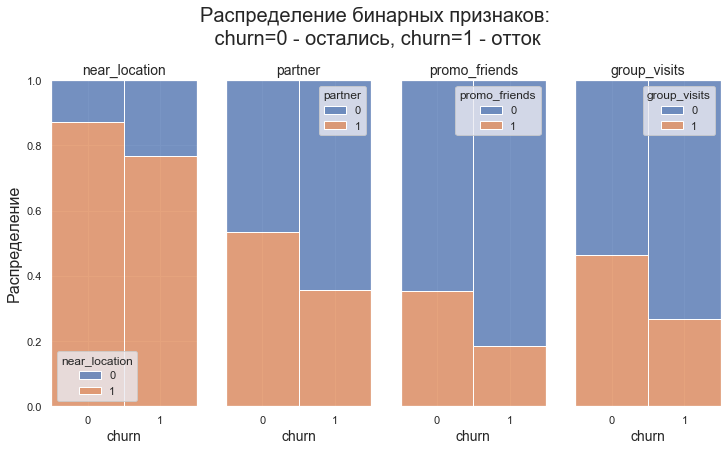

In [10]:
sns.set(style = 'darkgrid')
histplots_binary_attributes(
    gym_churn_drop_gf,
    'churn',
    binary_attributes_list,
    'Распределение бинарных признаков:\n churn=0 - остались, churn=1 - отток')

Графики отображают полученное ранее описание. **Для оттока характерно снижение доли клиентов:**
- **проживающих возле фитнес-центров;**
- **являющихся сотрудниками компаний-партнёров;**
- **пришедших по программе "пригласи друга";**
- **посещающих групповые занятия.**

Создадим функцию:

In [11]:
def captions_to_graphics(title, xlabel, ylabel):
    '''
    - принимает на вход: заголовок, подпись оси X, подпись оси Y
    - передаёт полученные значения графику, устанавливая определённые свойства:
    - выделяет тексты жирным, задаёт необходимую высоту
    '''
    plt.title(title,
              fontsize=16,
              fontweight='bold')
    plt.xlabel(xlabel,
               fontsize=13,
               fontweight='bold')
    plt.ylabel(ylabel,
               fontsize=13,
               fontweight='bold')    

Выведем графики распределения НЕ бинарных признаков циклом:

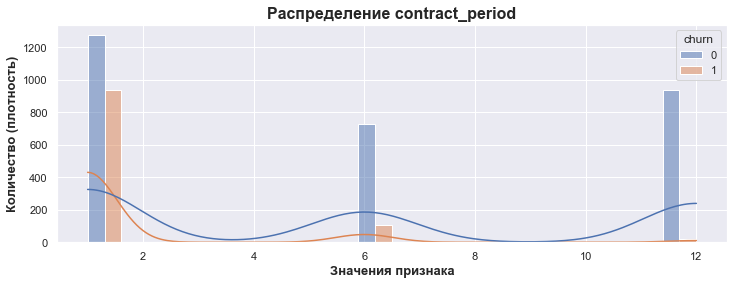

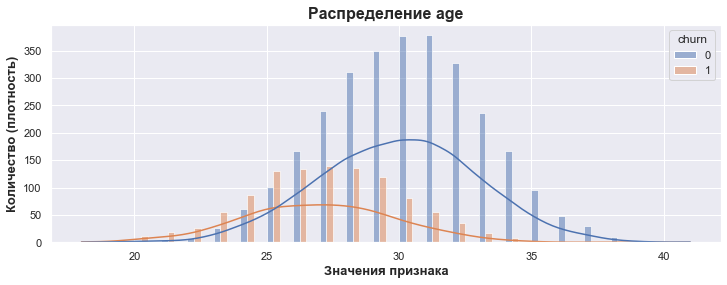

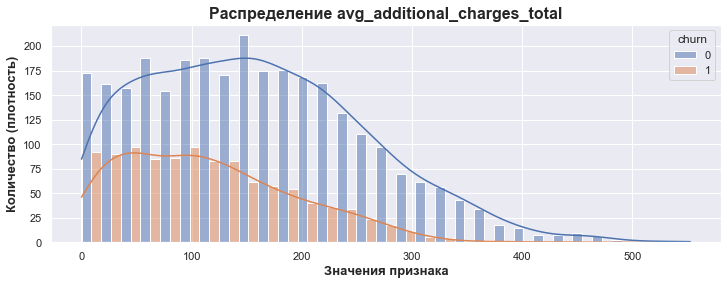

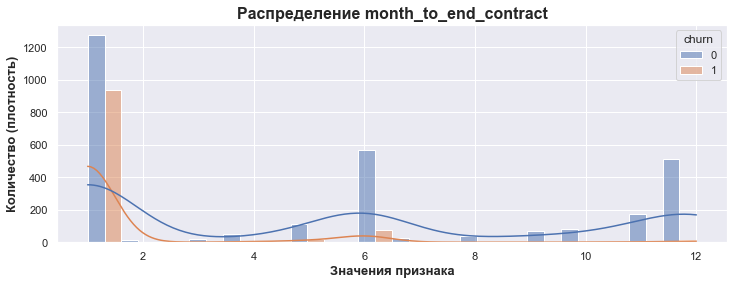

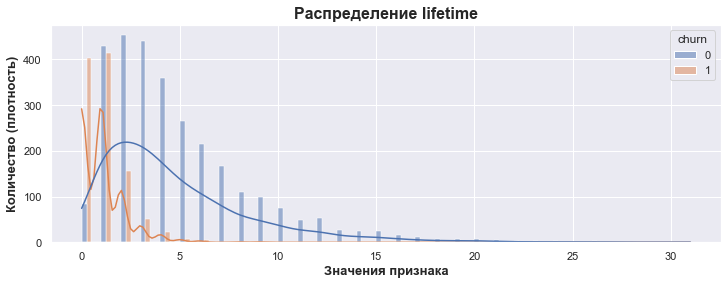

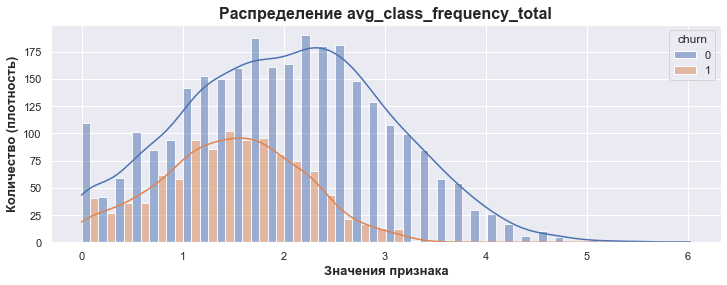

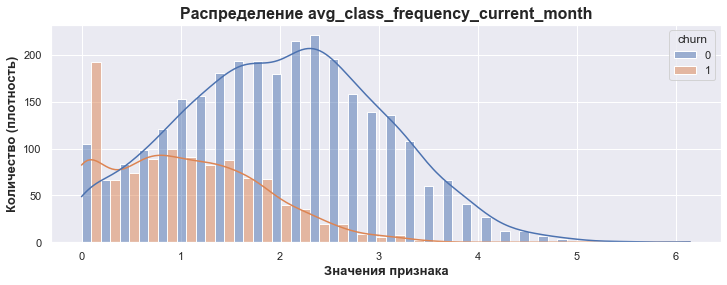

In [12]:
for column in gym_churn_drop_gf.drop('churn', axis=1).columns:
    if column not in binary_attributes_list:
        plt.figure(figsize=(12, 4))
        sns.histplot(data=gym_churn_drop_gf, x=column, hue='churn', multiple='dodge', kde=True)
        captions_to_graphics(
            'Распределение ' + column,
            'Значения признака',
            'Количество (плотность)')
plt.show()

Графики отображают полученное ранее описание. **Для оттока характерно снижение:**
- **времени абонемента (и месяцев до его окончания), и почти полное отсутствие годовых абонементов;**
- **возраста клиентов;**
- **суммарной выручки за время абонемента;**
- **времени жизни;**
- **количества занятий в неделю за всё время, и за последний месяц.**

Посмотрим матрицу корреляции  и отобразим

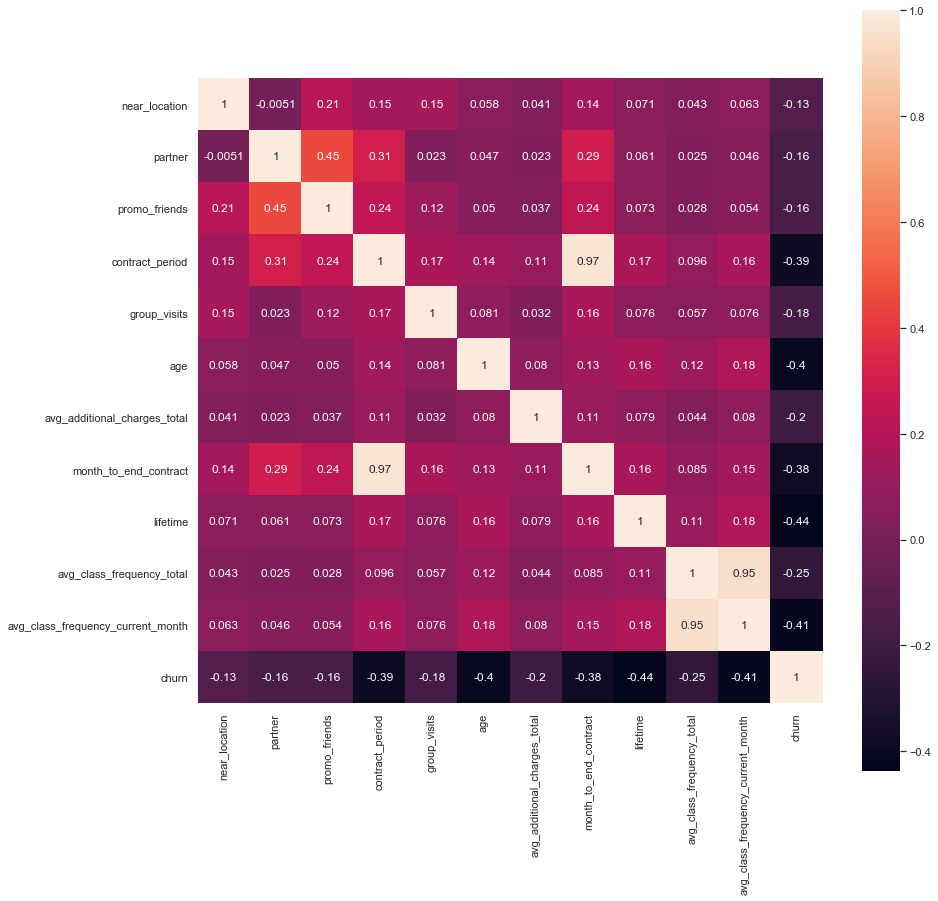

In [13]:
corr_m = gym_churn_drop_gf.corr()

plt.figure(figsize=(14, 14))
sns.heatmap(corr_m, square = True, annot=True)
plt.show()

В матрице отчётливо различимы два парных коррелирующих признака:
- **contract_period** / **month_to_end_contract** ("длительность абонемента" и "месяцев до окончания текущего действующего абонемента");
- **avg_class_frequency_total** / **avg_class_frequency_current_month** ("средняя частота посещений в неделю за все время с начала действия абонемента" и "средняя частота посещений в неделю за предыдущий месяц").

Необходимо от них избавиться. Из каждой пары оставляем тот признак, который сильнее коррелирует с характеристикой:
- **contract_period** (-0.39 против -0.38);
- **avg_class_frequency_current_month** (-0.41 против -0.25).

Иными словами:
- при наличии длительность абонемента, нас (алгоритм) не интересует, сколько осталось месяцев до его окончания;
- средняя частота посещений в неделю за предыдущий месяц гораздо сильнее влияет на отток, чем частота за всё время абонемента.

Удаляем столбцы:

In [14]:
gym_churn_clean = gym_churn_drop_gf.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)
gym_churn_clean.head().T

,0,1,2,3,4
near_location,1.00000,1.000000,1.000000,1.000000,1.000000
partner,1.00000,0.000000,1.000000,1.000000,1.000000
promo_friends,1.00000,0.000000,0.000000,1.000000,1.000000
contract_period,6.00000,12.000000,1.000000,12.000000,1.000000
group_visits,1.00000,1.000000,0.000000,1.000000,0.000000
age,29.00000,31.000000,28.000000,33.000000,26.000000
avg_additional_charges_total,14.22747,113.202938,129.448479,62.669863,198.362265
lifetime,3.00000,7.000000,2.000000,2.000000,3.000000
avg_class_frequency_current_month,0.00000,1.910244,1.736502,3.357215,1.120078
churn,0.00000,0.000000,0.000000,0.000000,0.000000


**Предложим заказчику отказаться от сбора данных по удалённым признакам.**

<a id=3></a>
# 3. Модель прогнозирования оттока пользователей.
[содержание](#content)

Построим модель бинарной классификации пользователей с целевым признаком - отток.  
Имеем ввиду, что целевой признак является нежелательным исходом для бизнеса.

Разделим DataFrame на матрицу признаков и вектор событий:

In [15]:
X = gym_churn_clean.drop('churn', axis=1)
y = gym_churn_clean['churn']

Разделим данные на обучающую и валидационную выборку в соотношении 80/20:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Стандартизируем признаки:

In [17]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель двумя способами: логистической регрессией, и случайным лесом. Результаты проверим метриками accuracy, precision и recall.

Создадим функцию:

In [18]:
def check_model_print_metrics(model, X_train, X_test, y_train, y_test):
    '''
    - принимает на вход тип модели и выборки (обучающая и валидационная);
    - формирует вектор событий;
    - рассчитывает метрику accuracy;
    - рассчитывает метрику precision;
    - рассчитывает метрику recall;
    - выводит на печать название модели, и полученные метрики.
    '''
    model_ = model[0]
    model_.fit(X_train, y_train)
    y_pred = model_.predict(X_test)
    print('\033[7m' + model[1], '\033[0m')
    print('\033[1m\033[46m',
          'Accuracy: {:.2f} | Precision: {:.2f} | Recall: {:.2f}'.format(
              accuracy_score(y_test, y_pred),
              precision_score(y_test, y_pred),
              recall_score(y_test, y_pred)),
          '\033[0m')

In [19]:
model_list = [
    [LogisticRegression(), 'Логистическая регрессия. LogisticRegression.'],
    [RandomForestClassifier(n_estimators = 100), 'Cлучайный лес. RandomForestClassifier.']
]
for model in model_list:
    check_model_print_metrics(model, X_train_st, X_test_st, y_train, y_test)

Логистическая регрессия. LogisticRegression. 
 Accuracy: 0.90 | Precision: 0.79 | Recall: 0.81 
Cлучайный лес. RandomForestClassifier. 
 Accuracy: 0.90 | Precision: 0.81 | Recall: 0.77 


Вспомним про различия метрик precision и recall.

$$Precission=\frac{TP}{TP+FP};\ \ Recall=\frac{TP}{TP+FN}$$

- **TP** - True Positive **«истинно положительные»** Прогноз модели = 1, реальное значение = 1.
- **FP** - False Positive **«ложно положительные»** Прогноз модели = 1, реальное значение = 0.
- **FN** - False Negative **«ложно отрицательные»** Прогноз модели = 0, реальное значение = 1.

Для прогноза оттока клиентов в фитнес-центре, лучше "диагностировать" ложный, чем пропустить истинный исход. Следовательно, модель должна выдывать минимальное количество ложно отрицательных прогнозов.  
**Выбираем метрику Recall, а с ней и модель обучения "логистическая регрессия", как наиболее оптимальный.**

<a id=4></a>
# 4. Кластеризация пользователей.
[содержание](#content)

Проведём стандартизацию данных:

In [20]:
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

Построим матрицу расстояний, а по ней - дендрограмму:

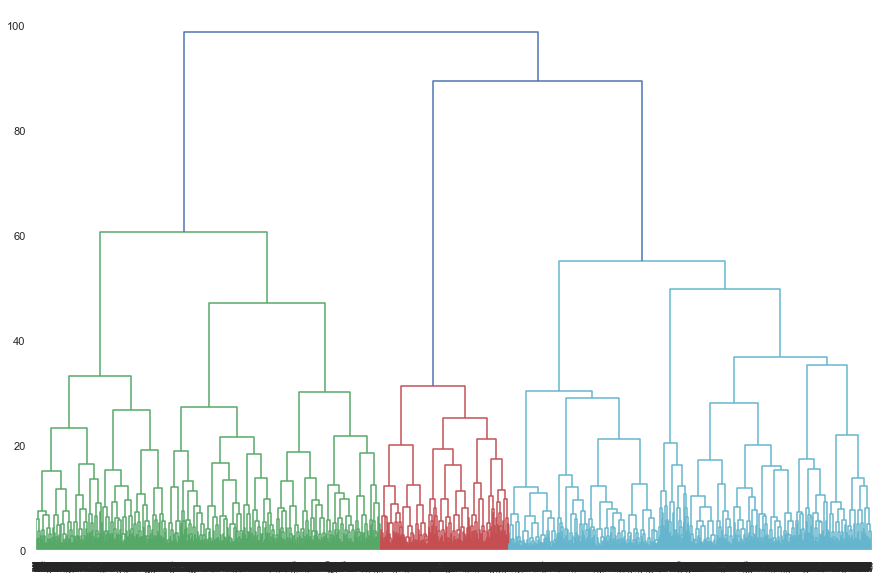

In [21]:
linked = linkage(X_st, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

**Можно выделить три кластера - по количеству цветов.**

Обучите модель кластеризации на основании алгоритма K-Means:

In [22]:
km = KMeans(n_clusters = 3, random_state=0)
labels = km.fit_predict(X_st)

Проверим среднее значение для кластеров:

In [23]:
gym_churn_original['cluster_km'] = labels
gym_churn_original.groupby('cluster_km').mean().T

cluster_km,0,1,2
gender,0.499187,0.521457,0.498914
near_location,0.000000,1.000000,0.997104
partner,0.489431,0.177146,0.934830
promo_friends,0.074797,0.061876,0.770456
phone,0.913821,0.900699,0.902969
contract_period,3.045528,3.047405,7.780594
group_visits,0.234146,0.393214,0.519189
age,28.713821,28.968563,29.706734
avg_additional_charges_total,137.450020,142.322743,157.877171
month_to_end_contract,2.873171,2.867764,7.079652


**Клиенты из кластера №2 имеют самый низкий отток.**  
**У них самые высокие средние значение по:**  
- **длительности абонемента;**
- **посещению групповых занятий;**
- **возрасту;**
- **средней выручке за время абонемента;**
- **времени жизни;**
- **среднему количеству посещений в неделю за последний месяц.**

Построим распределение признаков для кластеров. Выделим бинарные признаки:

In [24]:
binary_attributes_list_k = []
for column in gym_churn_original.drop('cluster_km', axis=1).columns:
    binary = len(gym_churn_original[column].value_counts())
    if binary == 2:
        binary_attributes_list_k.append(column)
binary_attributes_list_k

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'group_visits',
 'churn']

Построим графики для бинарных признаков и характеристики:

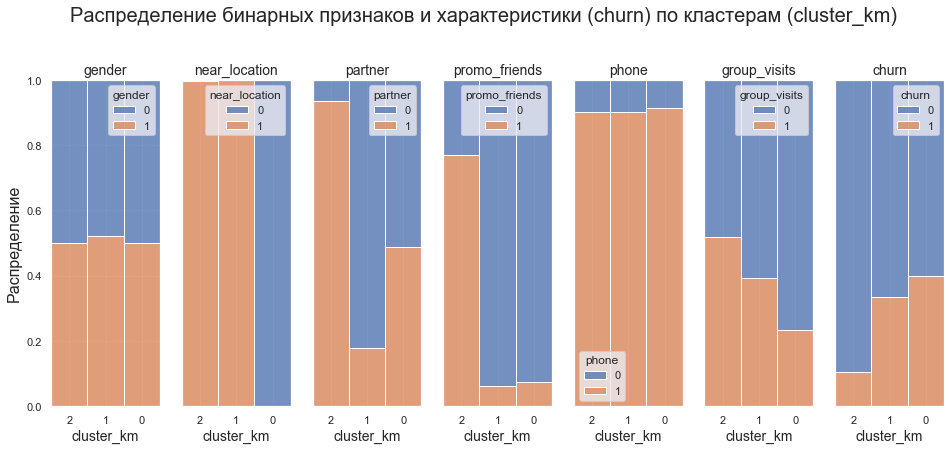

In [25]:
histplots_binary_attributes(
    gym_churn_original,
    'cluster_km',
    binary_attributes_list_k,
    'Распределение бинарных признаков и характеристики (churn) по кластерам (cluster_km)')

Исходя из процента оттока по кластерам, получается, что **не оказывают прямое влияние [на отток] следующие признаки:**
- **проживание возле фитнес-центров;**
- **сотрудник компании-партнёра;**
- **клиент, пришедший по программе "пригласи друга".**

Ранее, при рассмотрении распределений исходных данных с разбиением по оттоку, эти признаки читались, как значимые - влияющие на исход.

Построим графики для НЕ бинарных признаков:

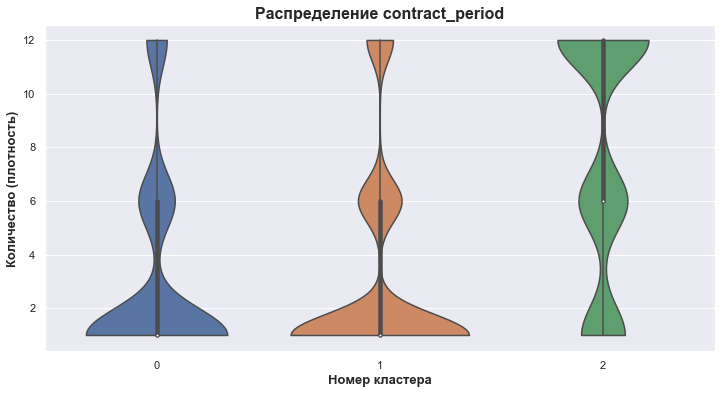

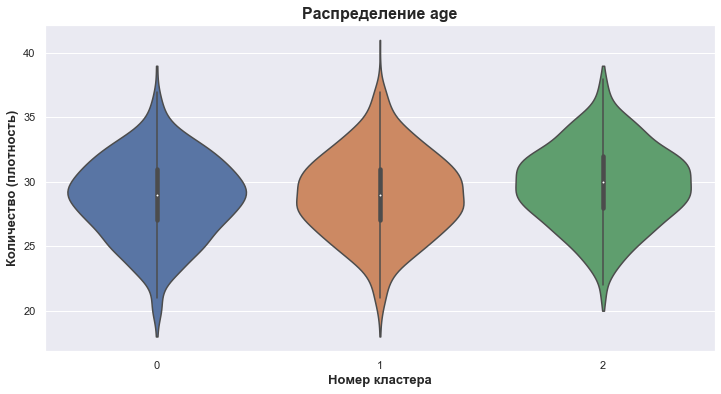

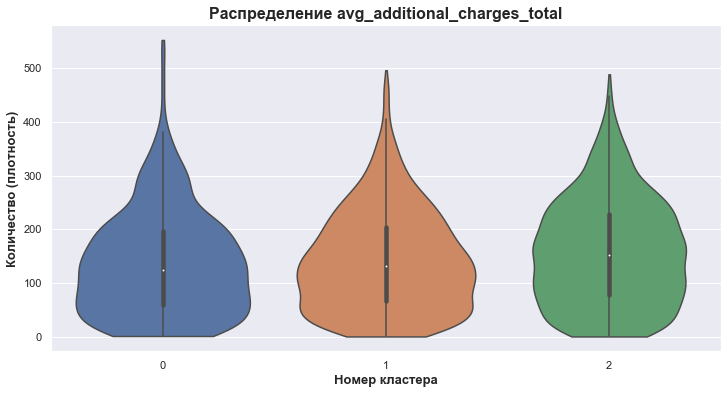

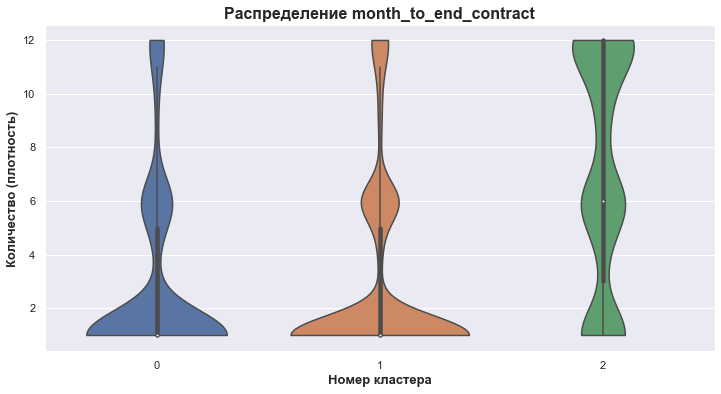

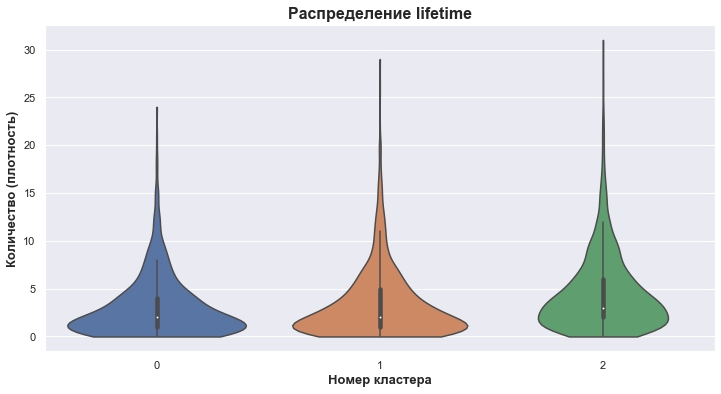

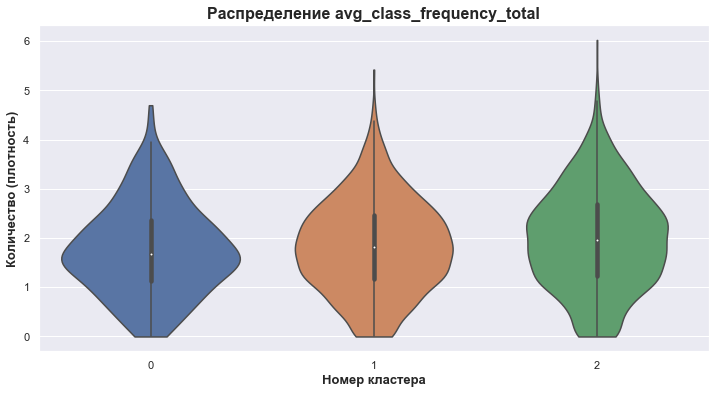

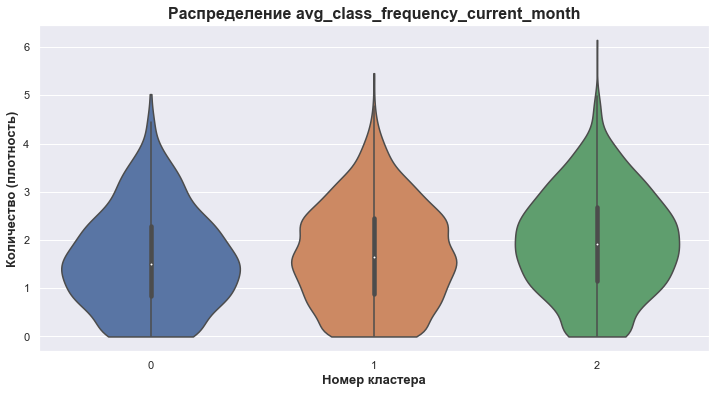

In [26]:
for column in gym_churn_original.drop('cluster_km', axis=1).columns:
    if column not in binary_attributes_list_k:
        plt.figure(figsize=(12, 6))
        sns.violinplot(x='cluster_km', y=column, data=gym_churn_original, cut=0)
        captions_to_graphics(
            'Распределение ' + column,
            'Номер кластера',
            'Количество (плотность)')
plt.show()

Вывод по распределениям повторяет описание таблицы со средними значениями. 

<a id=5></a>
# 5. Выводы и базовые рекомендации по работе с клиентами.
[содержание](#content)

**На снижение оттока влияет следующие признаки:**  
- **длительность абонемента;**
- **посещение групповых занятий;**
- **возраст;**
- **средняя выручке за время абонемента;**
- **время жизни;**
- **среднее количество посещений в неделю за последний месяц.**

### Для удержания клиентов рекомендуется: <br>1) предлагать более выгодные условия на годовые абонементы;<br>2) предлагать групповые занятия целевым группам;<br> 3) расширять необходимый ассортимент сопутствующей продукции (снижать на неё цену, предлагать бонусом за длительность посещений);<br> 4) помогать с тайм-менеджментом (напоминать о запланированных тренировках, поощрять за соблюдение режима).
